In [1]:
import os

import awkward as ak
import dask
import dask_awkward as dak
import hist
import numpy as np
from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from dask.diagnostics import ProgressBar
from hist.dask import Hist
from matplotlib import pyplot as plt
from utils import get_dataset_files

In [2]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.numpoints": 1,
        "axes.linewidth": 2,
        "legend.title_fontsize": 16,
        "axes.labelsize": 18,
        "legend.fontsize": 16,
    }
)

ptbins = [
    5,
    10,
    15,
    20,
    22,
    26,
    28,
    30,
    32,
    34,
    36,
    38,
    40,
    45,
    50,
    60,
    80,
    100,
    150,
    250,
    400,
]
etabins = [
    -2.5,
    -2.4,
    -2.3,
    -2.2,
    -2.1,
    -2.0,
    -1.9,
    -1.8,
    -1.7,
    -1.566,
    -1.4442,
    -1.3,
    -1.2,
    -1.1,
    -1.0,
    -0.9,
    -0.8,
    -0.7,
    -0.6,
    -0.5,
    -0.4,
    -0.3,
    -0.2,
    -0.1,
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
    1.1,
    1.2,
    1.3,
    1.4442,
    1.566,
    1.7,
    1.8,
    1.9,
    2.0,
    2.1,
    2.2,
    2.3,
    2.4,
    2.5,
]

In [3]:
LPC = False
dataset = "/EGamma*/Run2023C-PromptNanoAODv12_v4-v1/NANOAOD"

if LPC:
    egamma_datasets = (
        os.popen(f"dasgoclient --query='dataset dataset={dataset} status=*'")
        .read()
        .splitlines()
    )

    egamma_files = {}
    for dataset in egamma_datasets:
        files = get_dataset_files(dataset)[0]
        egamma_files[dataset] = files

    for dataset in egamma_datasets:
        print(f"Dataset {dataset} has {len(egamma_files[dataset])} files\n")
        print(f"First file of dataset {dataset} is {egamma_files[dataset][0]}\n")
        print(f"Last file of dataset {dataset} is {egamma_files[dataset][-1]}\n")

In [4]:
%%time
if LPC:
    fnames = {f: "Events" for k, files in egamma_files.items() for f in files}
else:
    fnames = {"root_files/Egamma0.root": "Events", "root_files/Egamma1.root": "Events"}

events = NanoEventsFactory.from_root(
    fnames,
    schemaclass=NanoAODSchema,
    permit_dask=True,
    chunks_per_file=1,
    metadata={"dataset": "Egamma"},
).events()

CPU times: user 790 ms, sys: 35.1 ms, total: 825 ms
Wall time: 894 ms


In [5]:
class DaskLumiMask:
    def __init__(self, lumimask):
        self._lumimask = lumimask

    def __call__(self, runs, lumis):
        out = self._lumimask(
            ak.typetracer.length_zero_if_typetracer(runs).to_numpy(),
            ak.typetracer.length_zero_if_typetracer(lumis).to_numpy(),
        )
        out = ak.Array(out)
        if ak.backend(runs, lumis) == "typetracer":
            out = ak.Array(
                out.layout.to_typetracer(forget_length=True), behavior=out.behavior
            )
        return out


def lumimask(events, jsonfile):
    eager_lumimask = LumiMask(jsonfile)
    dask_lumimask = DaskLumiMask(eager_lumimask)
    return dak.map_partitions(dask_lumimask, events.run, events.luminosityBlock)


def filter_events(events):
    events = events[dak.num(events.Electron) >= 2]
    abs_eta = abs(events.Electron.eta)
    pass_eta_ebeegap = (abs_eta < 1.4442) | (abs_eta > 1.566)
    pass_tight_id = events.Electron.cutBased == 4
    pass_pt = events.Electron.pt > 31
    pass_eta = abs_eta <= 2.5
    pass_selection = pass_pt & pass_eta & pass_eta_ebeegap & pass_tight_id
    n_of_tags = dak.sum(pass_selection, axis=1)
    good_events = events[n_of_tags >= 2]
    good_locations = pass_selection[n_of_tags >= 2]
    mask = lumimask(good_events, "json/Cert_Collisions2023_366442_368823_Golden.json")
    good_events_lumimasked = good_events[mask]
    good_locations_lumimasked = good_locations[mask]

    return good_events_lumimasked, good_locations_lumimasked


def trigger_match(electrons, trigobjs):
    pass_pt = trigobjs.pt > 31
    pass_id = abs(trigobjs.id) == 11
    pass_wptight = trigobjs.filterBits & (0x1 << 1) == 2
    trigger_cands = trigobjs[pass_pt & pass_id & pass_wptight]

    delta_r = electrons.metric_table(trigger_cands)
    pass_delta_r = delta_r < 0.1
    n_of_trigger_matches = dak.sum(dak.sum(pass_delta_r, axis=1), axis=1)
    trig_matched_locs = n_of_trigger_matches >= 1

    return trig_matched_locs


def find_probes(tags, probes, trigobjs):
    trig_matched_tag = trigger_match(tags, trigobjs)
    tags = tags[trig_matched_tag]
    probes = probes[trig_matched_tag]
    trigobjs = trigobjs[trig_matched_tag]

    dr = tags.delta_r(probes)
    mass = (tags + probes).mass

    in_mass_window = abs(mass - 91.1876) < 30
    opposite_charge = tags.charge * probes.charge == -1

    isZ = in_mass_window & opposite_charge
    dr_condition = dr > 0.0

    all_probes = probes[isZ & dr_condition]
    trig_matched_probe = trigger_match(all_probes, trigobjs)
    passing_probes = all_probes[trig_matched_probe]

    return passing_probes, all_probes


def perform_tnp(events):
    good_events, good_locations = filter_events(events)
    ele_for_tnp = good_events.Electron[good_locations]

    zcands1 = dak.combinations(ele_for_tnp, 2, fields=["tag", "probe"])
    zcands2 = dak.combinations(ele_for_tnp, 2, fields=["probe", "tag"])
    p1, a1 = find_probes(zcands1.tag, zcands1.probe, good_events.TrigObj)
    p2, a2 = find_probes(zcands2.tag, zcands2.probe, good_events.TrigObj)

    return p1, a1, p2, a2


def replace_nans(arr):
    arr = np.array(arr)

    # Find the index of first non-nan value
    first_float_index = np.where(~np.isnan(arr))[0][0]

    # Create masks for before and after the first float
    before_first_float = np.arange(len(arr)) < first_float_index
    after_first_float = ~before_first_float

    # Replace all nans with 0 before first float number and with 1 after
    arr[before_first_float & np.isnan(arr)] = 0
    arr[after_first_float & np.isnan(arr)] = 1

    return arr

In [6]:
%%time

p1, a1, p2, a2 = perform_tnp(events)

CPU times: user 699 ms, sys: 13.4 ms, total: 712 ms
Wall time: 717 ms


In [7]:
%%time

ptaxis = hist.axis.Variable(ptbins, name="pt")
hpt_all = Hist(ptaxis)
hpt_pass = Hist(ptaxis)

etaaxis = hist.axis.Variable(etabins, name="eta")
heta_all = Hist(etaaxis)
heta_pass = Hist(etaaxis)

absetaaxis = hist.axis.Variable(np.unique(np.abs(etabins)), name="abseta")
habseta_all = Hist(absetaaxis)
habseta_pass = Hist(absetaaxis)

# Fill for p1, a1
hpt_all.fill(dak.flatten(a1.pt))
hpt_pass.fill(dak.flatten(p1.pt))

heta_all.fill(dak.flatten(a1.eta))
heta_pass.fill(dak.flatten(p1.eta))

habseta_all.fill(abs(dak.flatten(a1.eta)))
habseta_pass.fill(abs(dak.flatten(p1.eta)))

# Fill for p2, a2
hpt_all.fill(dak.flatten(a2.pt))
hpt_pass.fill(dak.flatten(p2.pt))

heta_all.fill(dak.flatten(a2.eta))
heta_pass.fill(dak.flatten(p2.eta))

habseta_all.fill(abs(dak.flatten(a2.eta)))
habseta_pass.fill(abs(dak.flatten(p2.eta)))

with ProgressBar():
    hpt_all, hpt_pass, heta_all, heta_pass, habseta_all, habseta_pass = dask.compute(
        hpt_all,
        hpt_pass,
        heta_all,
        heta_pass,
        habseta_all,
        habseta_pass,
        scheduler="threads",
    )

hptratio = hpt_pass / hpt_all
hptratio[:] = replace_nans(hptratio.values())

hetaratio = heta_pass / heta_all
hetaratio[:] = replace_nans(hetaratio.values())

habsetaratio = habseta_pass / habseta_all
habsetaratio[:] = replace_nans(habsetaratio.values())

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

[########################################] | 100% Completed | 212.38 ms
[########################################] | 100% Completed | 3.18 ss
Passing probes: 14598.0
All probes: 16896.0
CPU times: user 4.71 s, sys: 207 ms, total: 4.92 s
Wall time: 3.69 s


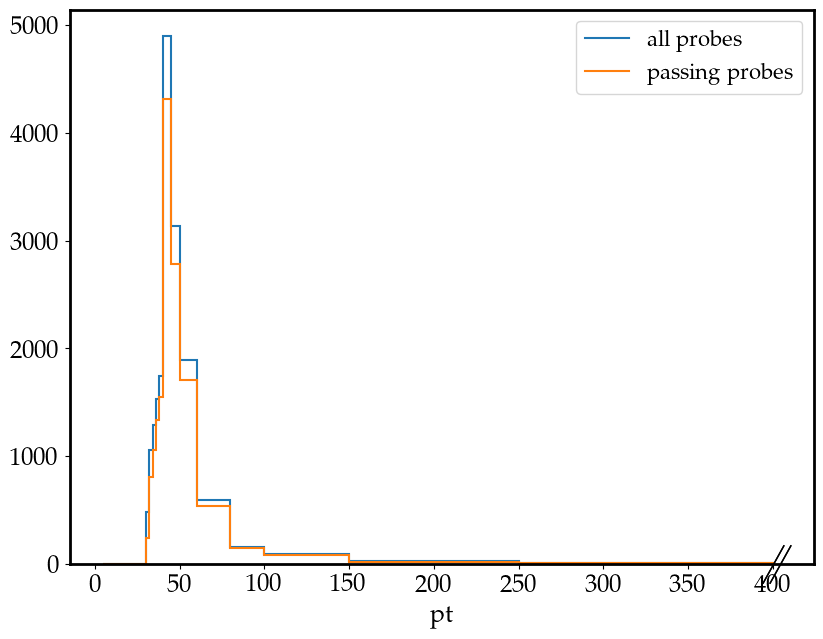

In [8]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hpt_all.plot1d(label="all probes")
hpt_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/pt.pdf", bbox_inches="tight")
plt.show()

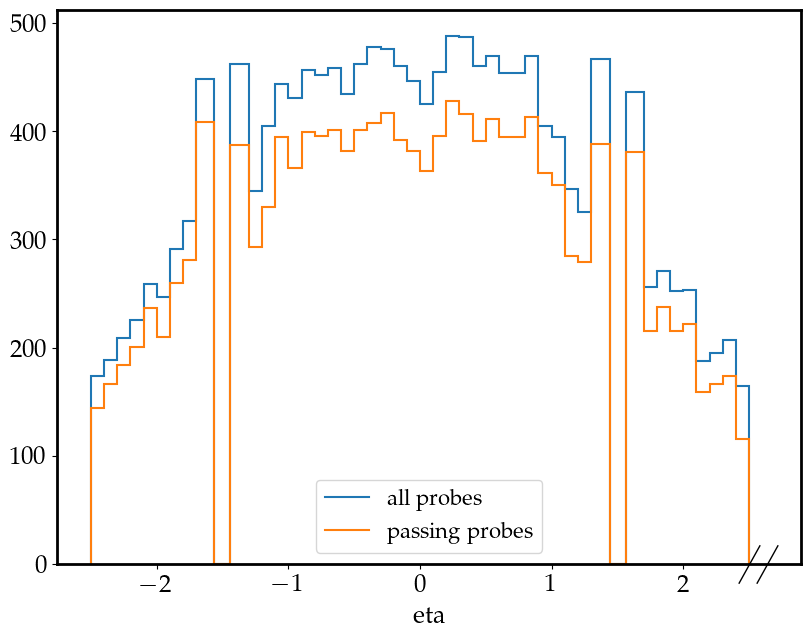

In [9]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
heta_all.plot1d(label="all probes")
heta_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/eta.pdf", bbox_inches="tight")
plt.show()

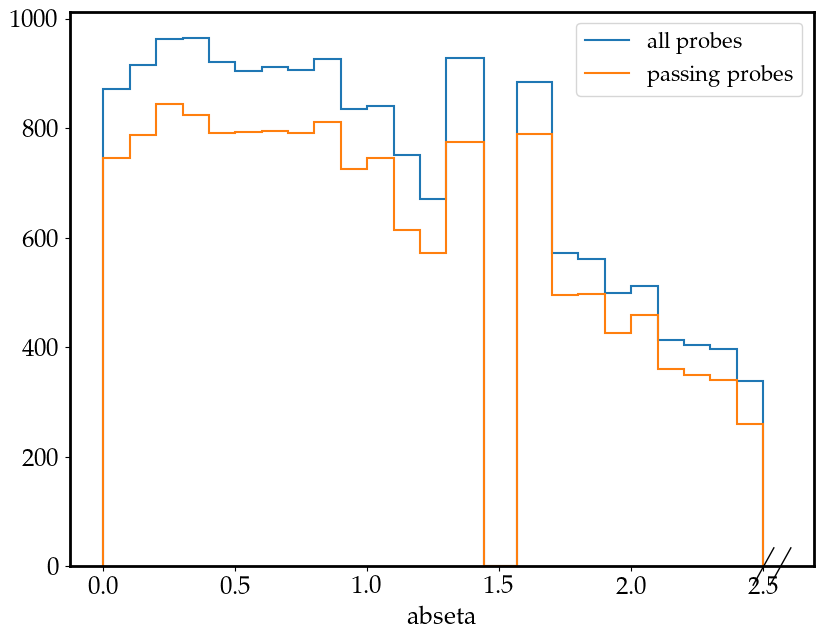

In [10]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
habseta_all.plot1d(label="all probes")
habseta_pass.plot1d(label="passing probes")
plt.legend()
plt.savefig("plots/abseta.pdf", bbox_inches="tight")
plt.show()

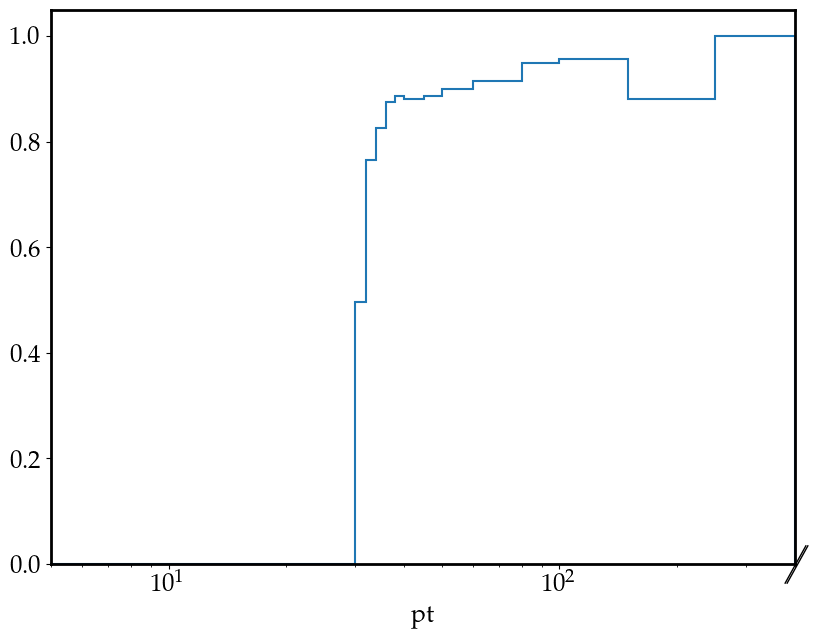

In [11]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hptratio.plot1d()
plt.xlim(5, 400)
plt.xscale("log")
plt.savefig("plots/eff_pt.pdf", bbox_inches="tight")
plt.show()

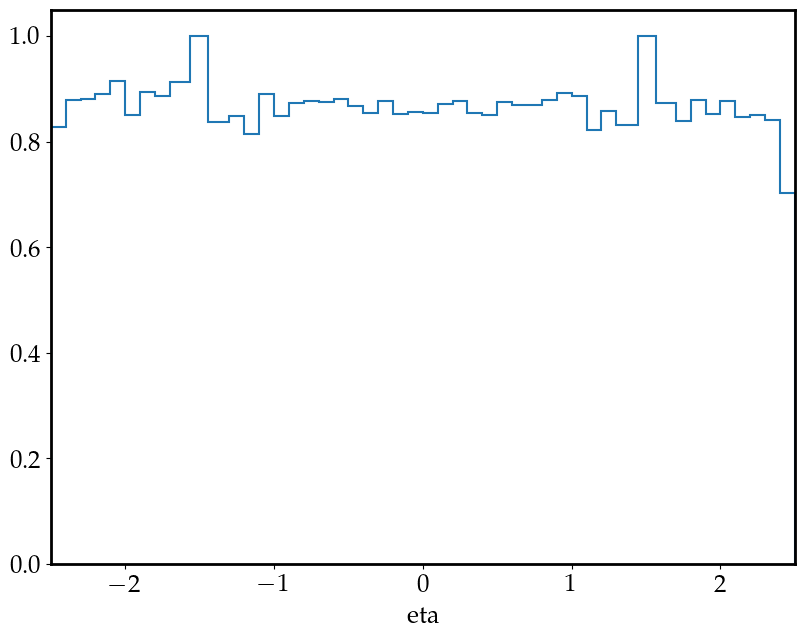

In [12]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
hetaratio.plot1d()
plt.xlim(-2.5, 2.5)
plt.savefig("plots/eff_eta.pdf", bbox_inches="tight")
plt.show()

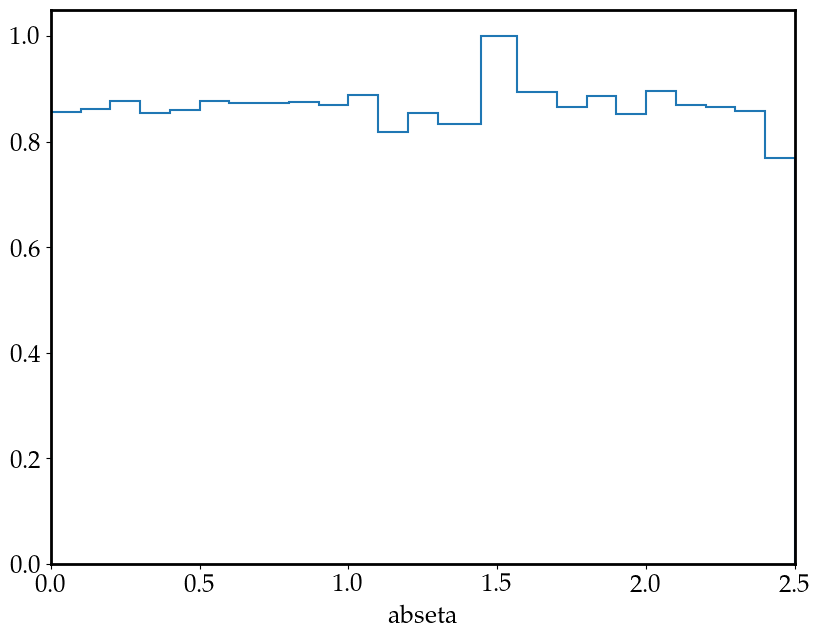

In [13]:
plt.figure(figsize=(6.4 * 1.5, 4.8 * 1.5))
habsetaratio.plot1d()
plt.xlim(0, 2.5)
plt.savefig("plots/eff_abseta.pdf", bbox_inches="tight")
plt.show()